# Preparation

## Imports

In [1]:
# TensorFlow
import tensorflow as tf
import tensorboard as tb
from tensorflow.keras.layers import Input, Layer, Conv2D, MaxPool2D, Flatten, Dense
# Data handling
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
# Other stuff
import itertools
import datetime
import time
import pickle
import functools
import json
import sys
import os
import shutil

## Paths

In [2]:
# Base path for functions
base_path = "C:/repos/"
sys.path.append(base_path)

# Path where configs are stored
configs_path = base_path + "twrds_unbiased_anns/configs/"

# Path top store runs
runs_path = base_path + "twrds_unbiased_anns/runs/"

# Path to store run results
results_path = base_path + "twrds_unbiased_anns/runs/results/"

## Functions

In [3]:
# Import of functions
# Sample creation
from twrds_unbiased_anns.src.data.samples import create_sample_array, get_sample_data, get_sample_params, convert_sample_to_np_array, gen_from_sample, dataset_from_gen
# Evaluation
from twrds_unbiased_anns.src.data.eval import load_eval_samples, evaluate_performance, evaluate_performance_class, evaluate_model, store_results
# Models
from twrds_unbiased_anns.src.tf.models import get_model
# Losses
from twrds_unbiased_anns.src.tf.losses import get_loss
# Optimizers
from twrds_unbiased_anns.src.tf.optimizers import get_optimizer
# Utils
from twrds_unbiased_anns.src.utils import load_config_from_file, mkdir, rmdir

# Model

## Gradient Reversal Layer
https://stackoverflow.com/questions/56841166/how-to-implement-gradient-reversal-layer-in-tf-2-0

In [5]:
# Gradient reversal operation
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

# Layer that reverses the gradient
class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

In [6]:
def create_grad_model(n_attributes, attr_loss_weight, classification = False):
    
    # Input
    model_input = Input(shape=(360, 360, 3), name="input_img")

    # Feature extractor
    x = Conv2D(32, (3, 3), padding = "same", activation = "relu", name = "conv_1")(model_input)
    x = MaxPool2D(pool_size = (2, 2), name = "pool_1")(x)
    x = Conv2D(64, (3, 3), padding = "same", activation = "relu", name = "conv_2")(x)
    x = MaxPool2D(pool_size = (2, 2), name = "pool_2")(x)
    x = Conv2D(64, (3, 3), padding = "same", activation = "relu", name = "conv_3")(x)
    x = Flatten(name = "flat_1")(x)

    # Target branch
    x_target = Dense(100, activation='relu', name = "target_dense_1")(x)
    x_target = Dense(20, activation='relu', name = "target_dense_2")(x_target)
    if classification:
        target_output = Dense(1, activation = "sigmoid", name = "target_output")(x_target)
    else:
        target_output = Dense(1, name = "target_output")(x_target)
    model_outputs = [target_output]
    
    # Create losses, weights and metrics
    if classification:
        losses = {'target_output': tf.keras.losses.BinaryCrossentropy()}
    else: 
        losses = {'target_output': tf.keras.losses.MeanSquaredError()}
    weights = {'target_output': 1.}
    metrics = {'target_output': 'accuracy'}
    
    # Split attribute loss over branches
    attr_branch_weight = attr_loss_weight / n_attributes
    
    # Attribute branches
    for i in range(n_attributes):
        # Gradient reversal layer
        x_attr = GradReverse()(x)
        # Funnel into sigmoid for binary classification of attributes
        x_attr = Dense(100, activation='relu', name = "attr_{}_dense_1".format(i))(x_attr)
        x_attr = Dense(20, activation='relu', name = "attr_{}_dense_2".format(i))(x_attr)
        output_name = "attr_{}_output".format(i)
        attr_output = Dense(1, activation = "sigmoid", name = output_name)(x_attr) 
        # Add to outputs
        model_outputs.append(attr_output)
        # Add to losses, weights and metrics
        losses[output_name] = tf.keras.losses.BinaryCrossentropy()
        weights[output_name] = attr_branch_weight
        metrics[output_name] = 'accuracy'
        
    # Make model
    model = tf.keras.Model(inputs = model_input, outputs = model_outputs, name = "GRAD_CNN")   
    
    # Compile model
    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = losses, loss_weights = weights, metrics=metrics)
    
    # Return finished model
    return model

In [7]:
model = create_grad_model(2, 1000)

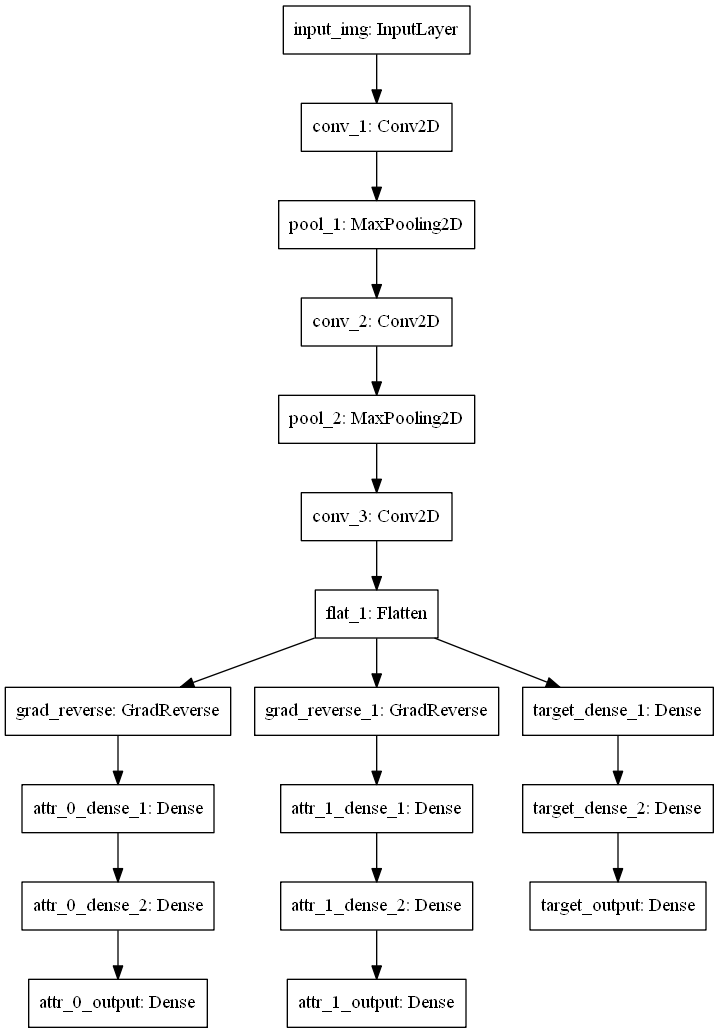

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# Config

In [8]:
# Set name for this run
run_name = "GRAD_test" # Also name of the config file

# Set run directory
run_dir = runs_path + run_name

# Get current date
cur_date = datetime.datetime.today()
date_str = cur_date.strftime("%d-%m-%Y")

# Load all variables from config file
#config_filename = run_name + ".json"
#name, eval_sample_filename, dataset_size, colors, optimizer, repeats_per_model, batch_size, n_epochs, mean_diffs, stddevs, minority_shares, categorical, models, loss_functions, thresholds, noises = load_config_from_file(configs_path + config_filename, "class")

# Create directory for this run
mkdir(run_dir)

# Create logdir
log_base_dir = run_dir + "/logs/"
mkdir(log_base_dir)

[WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:/repos/twrds_unbiased_anns/runs/GRAD_test'
Deleting directory and creating again ...


# Training

## TensorBoard Setup

In [10]:
# Delete tensorboard temp dir
#rmdir("C:/Users/lucas/AppData/Local/Temp/.tensorboard-info")
# Load Tensorboard
%reload_ext tensorboard
%tensorboard --logdir=$log_base_dir

Reusing TensorBoard on port 6006 (pid 5464), started 0:01:00 ago. (Use '!kill 5464' to kill it.)

In [11]:
dataset_size = 400
batch_size = 16
category = "shape"
m_diff = 50
std = 3
share = 50
threshold = 75
noise = 0
n_epochs = 50
colors = ["red"]

In [12]:
# Calculate number of steps per epoch
n_steps = int(dataset_size/batch_size)

# Clear session once and then every time before a new model is trained
tf.keras.backend.clear_session()

# Get sample parameters
white_square, white_circle, colorful_square, colorful_circle = get_sample_params(category, m_diff, std, share)

# Prepare sample
train_sample = create_sample_array(dataset_size, white_square, white_circle, colorful_square, colorful_circle)

# Create dataset from training data sample
data = dataset_from_gen(train_sample, n_epochs, batch_size, colors, task_type = "class", threshold = threshold, noise = noise) 

In [13]:
model = create_grad_model(2, 0)

n_steps = int(dataset_size/batch_size)
# Create logdir and callback
logdir = log_base_dir + "GRAD_test_0"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

# Do training
model.fit(data, epochs = n_epochs, steps_per_epoch = n_steps, verbose = 0, callbacks=[tensorboard_callback])